# check the grid of speedyfit

In [1]:
from astropy.io import fits
from astropy import units, constants
import joblib
from speedysedfit.tlustysed import rsed
from speedysedfit.broadsed import vgconv
import numpy as np
from speedysedfit.model import get_table_single
from glob import glob
import os

In [2]:
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('lijiaostyle')

# check kurucz93_z0.0_k2odfnew_sed.fits

In [54]:
fname = '/share/lijiao/speedyfit/modelgrids/kurucz93_z0.0_k2odfnew_sed.fits'
hdulist = fits.open(fname)

In [55]:
hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =                 1221 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'wavelength'                                                          
TFORM1  = 'E       '                                                            
TTYPE2  = 'flux    '                                                            
TFORM2  = 'E       '                                                            
EXTNAME = 'T03500_logg0.00' 

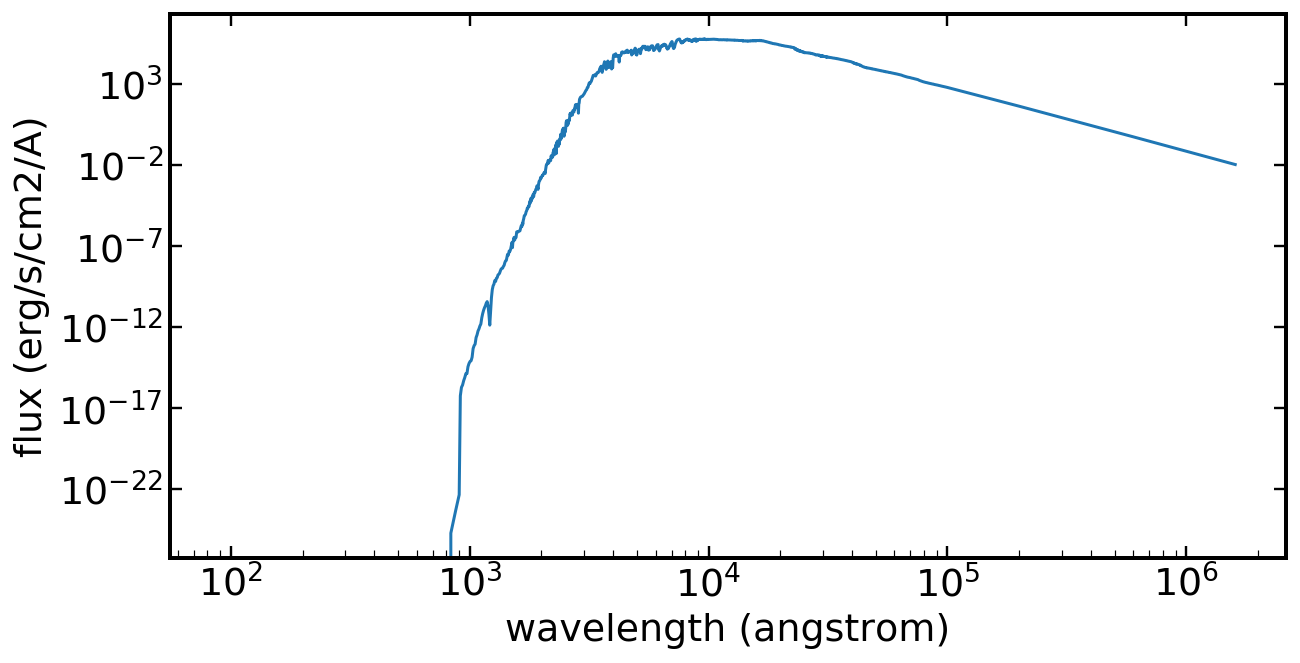

1221


In [56]:
fig, ax = plt.subplots(1, 1, figsize=[10,5])
data = hdulist[4].data
plt.plot(data['wavelength'], data['flux'])
plt.xlabel('wavelength (angstrom)')
plt.ylabel('flux (erg/s/cm2/A)')
plt.semilogx()
plt.semilogy()
plt.show()
print(len(data))

# check ifname = ikurucz93_z0.0_k2odfnew_sed_lawfitzpatrick2004_Rv3.10.fits

In [6]:
ifname = '/share/lijiao/speedyfit/modelgrids/ikurucz93_z0.0_k2odfnew_sed_lawfitzpatrick2004_Rv3.10.fits'
ihdulist = fits.open(ifname)

In [7]:
Teff = ihdulist[1].data['Teff']
logg = ihdulist[1].data['logg']
ebv = ihdulist[1].data['ebv']


In [8]:
ihdulist[1].data['GALEX.NUV']

array([1.58391356e+00, 1.18444858e+00, 8.86033755e-01, ...,
       4.69415925e+04, 3.44325839e+04, 2.52776405e+04])

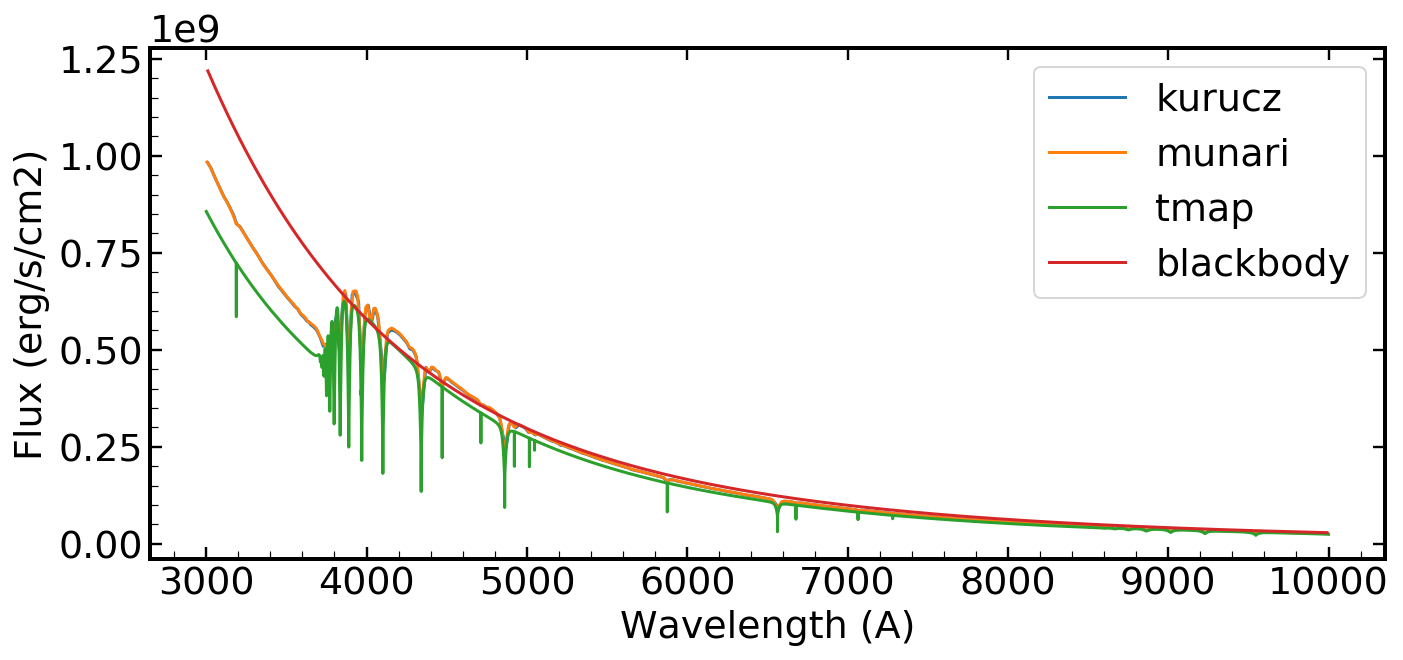

In [9]:
grids = ['kurucz', 'munari', 'tmap', 'blackbody']

plt.figure(figsize=(10,5))

for grid in grids:

    wave, flux = get_table_single(teff=20000, logg=5.0, ebv=0.0, grid=grid)
    s = np.where((wave > 3000) & (wave<10000))
    plt.plot(wave[s], flux[s], label=grid)

plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (erg/s/cm2)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# compare TLUSTY SED and Kurucz SED

1221
len(wT) = 3385


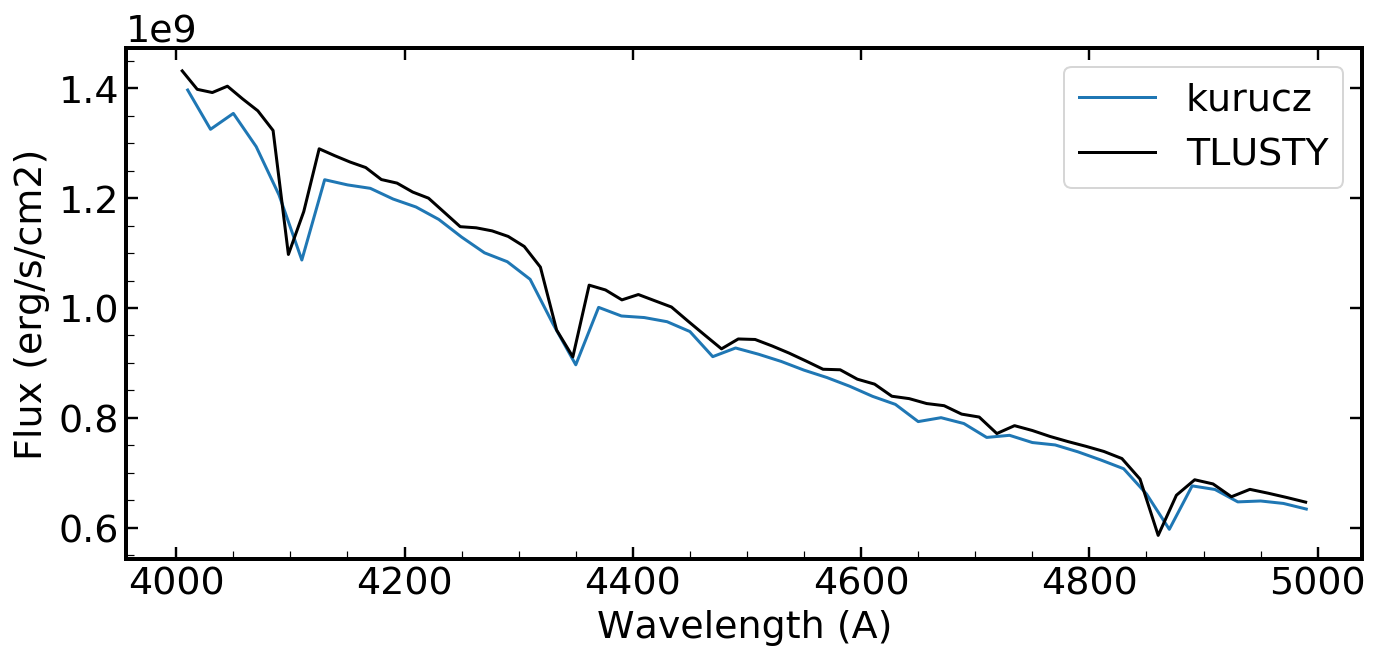

In [10]:
import numpy as np
from speedysedfit.model import get_table_single
from speedysedfit.tlustysed import rsed
from speedysedfit.broadsed import vgconv

ffname = '/share/lijiao/TLUSTY_grid/wangluqian/Tlusty/G30000g450v10.flux'
grids = ['kurucz',]# 'munari', 'tmap', 'blackbody']

plt.figure(figsize=(10,5))

for grid in grids:

    wave, flux = get_table_single(teff=30001, logg=4.5, ebv=0.0, grid=grid)
    print(len(wave))
    s = np.where((wave > 2000) & (wave<10000))
    s = np.where((wave > 4000) & (wave<5000))
    plt.plot(wave[s], flux[s], label=grid)
    #pl.plot(wave, flux, label=grid)
    
  
wcor, fcor = rsed(ffname)
clight = 299792.458
#ind = (wcor > 2000) & (wcor < 10000)
#plt.plot(wcor[ind], fcor[ind], 'k')
#plt.plot(wave0[ind], flux0[ind], 'k')

w1, fbin = vgconv(wcor, fcor,clight/300, ppr=1)
print(f'len(wT) = {len(w1)}')
ind = (w1 > 2000) & (w1 < 10000)
ind = (w1 > 4000) & (w1 < 5000)
fbin2 = np.interp(wave, w1, fbin)
plt.plot(w1[ind], fbin[ind], 'k', label='TLUSTY')
#plt.plot(w1, fbin, 'k', label='TLUSTY')
ind = (wave > 2000) & (wave < 20000)
#plt.plot(wave[ind], fbin2[ind], 'k')



plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (erg/s/cm2)')
plt.legend(loc='best')
plt.tight_layout()
#plt.semilogx()
#plt.semilogy()
plt.show()

# check spectrum with resolution of R=200 of [COMARCS](http://stev.oapd.inaf.it/atm/lrspe.html)

In [95]:
dire_comarcs = '/share/lijiao/COMARCS/lrspec/isp'

filelist = glob(os.path.join(dire_comarcs, 'mxcom09v06_t3700_g+450_m0100*'))

def read_comarcs_spec(fname):
    '''read spec of comarcs
    returns:
    ------------
    wave [array] - wavelength [Å]; 
    flux_norm: [array] F/F(Cont) - continuum normalized flux (normalized to calculation without atomic and molecular line opacities); 
    L: [array] νL(ν) - frequency times specific luminosity [erg/s]; 
    fmean [array] flux devided by its mean value
    flam [array] flux [erg/s/cm2/AA]
    '''
    wave, flux_norm, nuLnu, fmean = np.loadtxt(fname, unpack=True)
    basename = os.path.basename(fname)
    paras = basename.split('_')
    teff = np.float(paras[1][1:])
    logg = np.float(paras[2][1:])/100
    m = np.float(paras[3][1:])/100

    ratio = 5.996233e-28 # 1/(4pi R^2) = (1 cm/s2) /G * 1*Msun/4*pi =5.996233e−28
    flam = nuLnu*10**logg/m *ratio/wave

    return wave, flux_norm, nuLnu, fmean, flam

In [96]:
filelist

['/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o930_c904_fe806_xi25_c09b.isp',
 '/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o680_c654_fe556_xi25_c09b_h2o-bt2.isp',
 '/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o980_c954_fe856_xi25_c09b.isp',
 '/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o680_c654_fe556_xi25_c09b.isp',
 '/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o880_c824_fe706_xi25_c09b.isp',
 '/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o730_c704_fe606_xi25_c09b.isp',
 '/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o730_c704_fe606_xi25_c09b_h2o-bt2.isp',
 '/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o980_c954_fe856_xi25_c09b_h2o-bt2.isp',
 '/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o880_c824_fe706_xi25_c09b_h2o-bt2.isp',
 '/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o930_c904_fe806_xi25_c09b_h2o-bt2.isp']

$f_{\nu} \Delta \nu = f_{\lambda} \Delta \lambda$

$\nu = \frac{c}{\lambda}$

--> $f_{\lambda} = f_{\nu} |\frac{d \nu}{d \lambda}| = f_{\nu} \frac{c}{\lambda^2} = \nu f_{\nu} \frac{1}{\lambda} $ 

1221


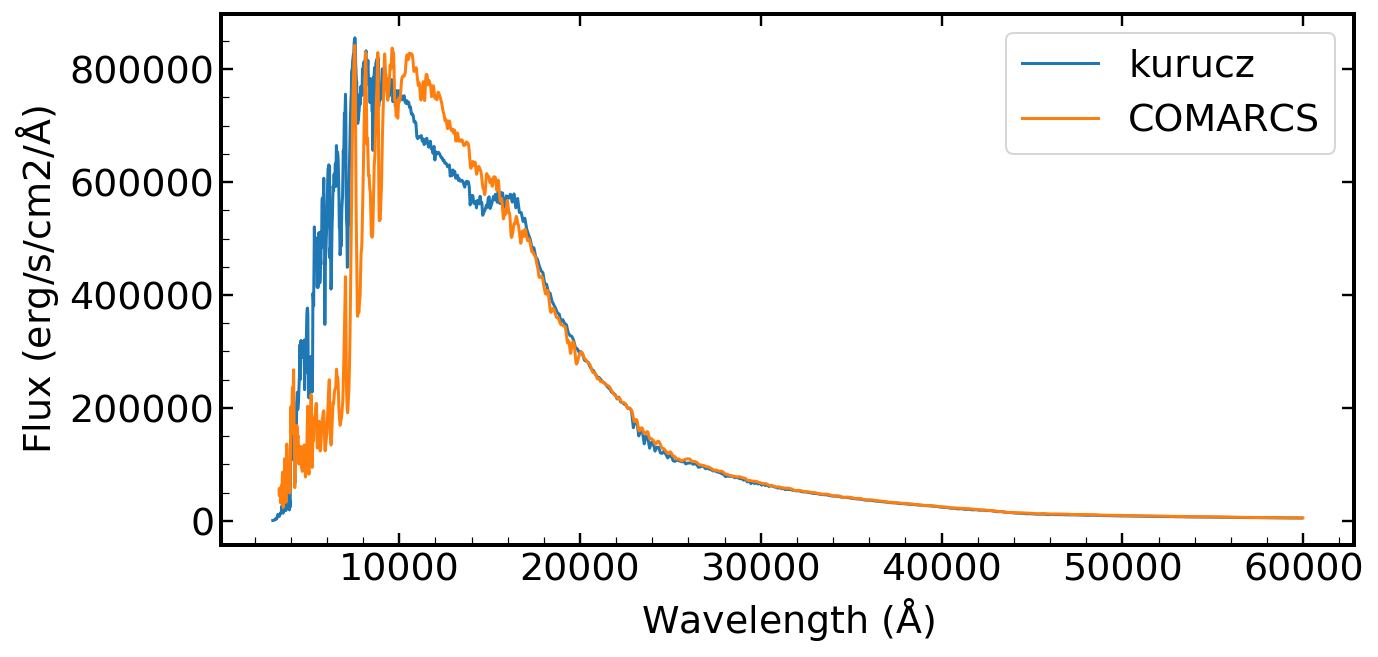

In [97]:
grids = ['kurucz',]# 'munari', 'tmap', 'blackbody']

plt.figure(figsize=(10,5))

xlim0, xlim1 =3000, 60000

for grid in grids:

    wave, flux = get_table_single(teff=3700, logg=2, ebv=0.0, grid=grid)
    print(len(wave))
    s = np.where((wave > xlim0) & (wave<xlim1))
    plt.plot(wave[s], flux[s], label=grid)
    #pl.plot(wave, flux, label=grid)

fname = filelist[7]
wave, flux_norm, nuLnu, fmean, flam = read_comarcs_spec(fname)



s = np.where((wave > xlim0) & (wave<xlim1))

plt.plot(wave[s], flam[s], label='COMARCS')

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux (erg/s/cm2/$\AA$)')
plt.legend(loc='best')
plt.tight_layout()
#plt.semilogx()
#plt.semilogy()
plt.show()

/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o930_c904_fe806_xi25_c09b.isp
1.02403e+31
/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o680_c654_fe556_xi25_c09b_h2o-bt2.isp
1.07848e+31
/share/lijiao/COMARCS/lrspec/isp/mxcom09v06_t3700_g+450_m0100_o980_c954_fe856_xi25_c09b.isp
9.69087e+30


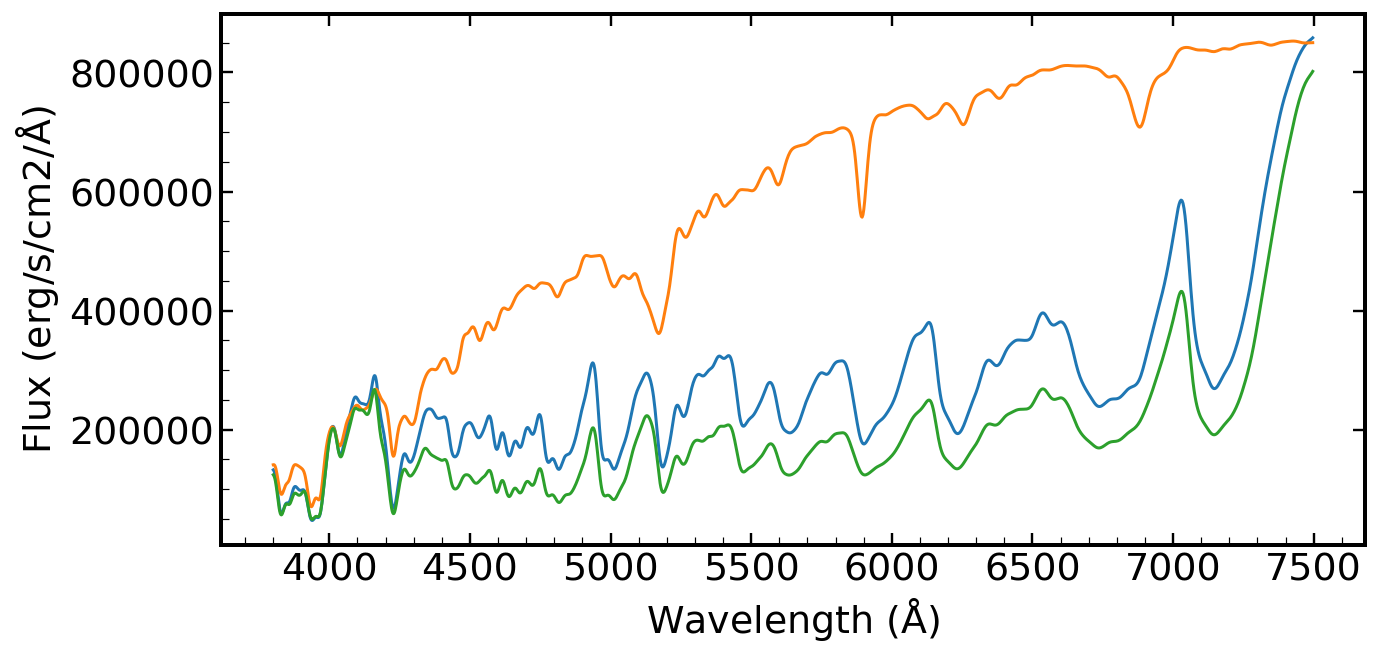

In [101]:
plt.figure(figsize=(10,5))

xlim0, xlim1 =3800, 7500
for fname in filelist[0:3]:
    print(fname)
    wave, flux_norm, nuLnu, fmean, flam = read_comarcs_spec(fname)
    print(np.median(nuLnu[0]))
    
    s = np.where((wave > xlim0) & (wave<xlim1))
    plt.plot(wave[s], flam[s], label='COMARCS')
    
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux (erg/s/cm2/$\AA$)')
    #plt.legend(loc='best')
    plt.tight_layout()
    #plt.semilogx()
    #plt.semilogy()


plt.show()

In [85]:
def plot_parsspace(Tteff, Tlogg, Tz, figtitle=None):
    fig = plt.figure(figsize=[14, 7])
    if figtitle is not None:
       fig.suptitle(figtitle, fontsize=16)
    axs = fig.subplots(nrows=1, ncols=2)
    axs[0].scatter(Tteff, Tlogg)
    axs[0].set_xlabel(r'$T \rm{eff}$', fontsize=20)
    axs[0].set_ylabel(r'$log \rm{g}$', fontsize=20)
    axs[0].invert_yaxis()
    axs[0].invert_xaxis()
    
    axs[1].scatter(Tteff, Tz)
    axs[1].set_xlabel(r'$T \rm{eff}$', fontsize=20)
    axs[1].set_ylabel(r'$Z/Z_{\odot}$', fontsize=20)
    axs[1].invert_xaxis()
    return fig, axs

In [71]:
dirout = '/share/lijiao/speedyfit/modelgrids/'
hduls = fits.open(dirout+'COMARCS.fits')
teffs = []
loggs = []
OHs   = [] #log(eps(O)/eps(H)) + 12
CHs   = []
FeHs  = []
Xis   = [] #microturbulence velocity (km/s)
for hdu in hduls[1:]:
    teffs.append(float(hdu.header['TEFF']))
    loggs.append(float(hdu.header['LOGG']))
    OHs.append(float(hdu.header['OH']))
    CHs.append(float(hdu.header['CH']))
    FeHs.append(float(hdu.header['FeH']))
    Xis.append(float(hdu.header['Vt']))


Text(0, 0.5, '$log(\\epsilon(Fe)/\\epsilon(H)) +12$')

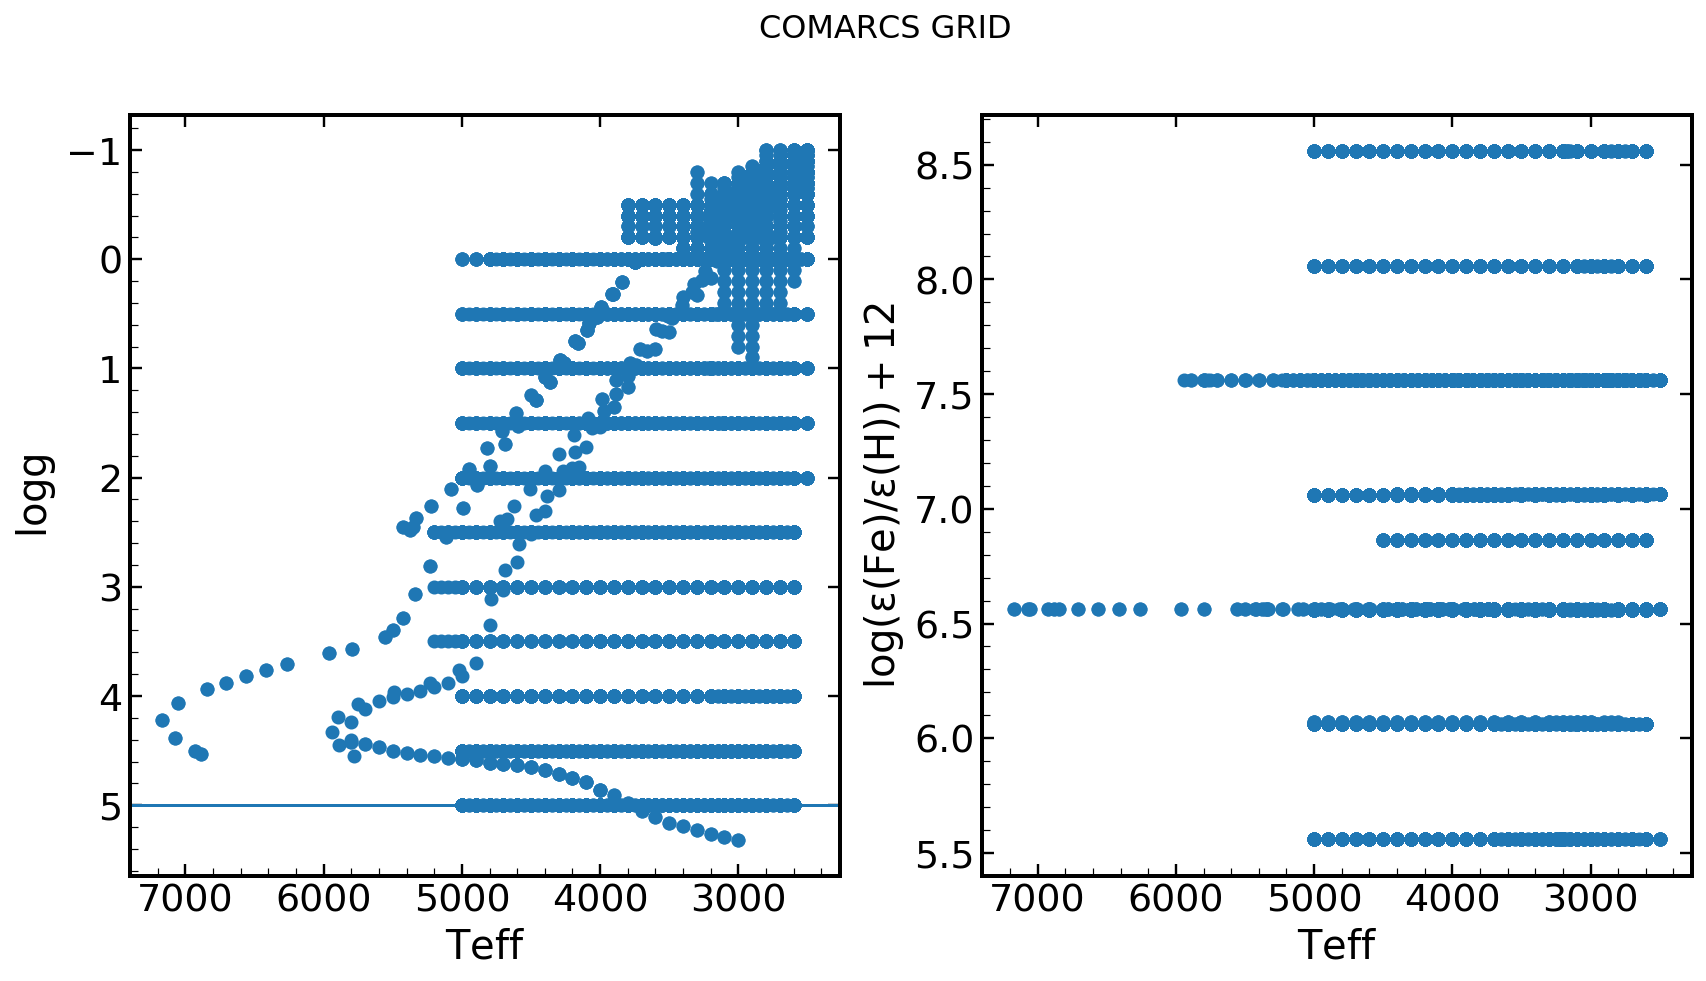

In [92]:
fig, axs = plot_parsspace(teffs, loggs, FeHs, figtitle='COMARCS GRID')
plt.sca(axs[0])
plt.axhline(y=5)
plt.sca(axs[1])
plt.ylabel('$log(\epsilon(Fe)/\epsilon(H)) +12$')

In [80]:
service = pyvo.dal.TAPService(catalog

-1.0

In [ ]:
plt.su